In [1]:
%matplotlib inline
import re, pickle, collections, bcolz, numpy as np, keras, sklearn, math, operator, pdb

Using TensorFlow backend.


In [286]:
from gensim.models import word2vec, KeyedVectors
import torch, torch.nn as nn
from torch.autograd import Variable
from torch import optim
from torchvision.models import inception_v3
import torch.nn.functional as F
from keras.preprocessing.sequence import pad_sequences
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
import re
from os import path
from torch.utils.data import DataLoader

from PIL import Image

In [284]:
dpath = '/data/image_captioning/flikr8/'
imgpath =  '/data/image_captioning/flikr8/Flicker8k_Dataset/' 
imgpath4loader = '/data/image_captioning/flikr8/Flicker8k_Dataset/' 
embed_path = '/data/word_embed/glove.6B.300d.txt'
BATCH_SIZE=4

In [5]:
tr_caps = pickle.load(open(dpath+'train_first_caps.pkl', 'rb'))
#pickle.dump(qs, open(dpath+'fr-en-qs.pkl', 'wb'))

In [6]:
tr_caps[0]

('1000268201_693b08cb0e.jpg',
 'A child in a pink dress is climbing up a set of stairs in an entry way .')

In [7]:
re_apos = re.compile(r"(\w)'s\b")         # make 's a separate word
re_mw_punc = re.compile(r"(\w[’'])(\w)")  # other ' in a word creates 2 words
re_punc = re.compile("([\"().,;:/_?!—])") # add spaces around punctuation
re_mult_space = re.compile(r"  *")        # replace multiple spaces with just one

def simple_toks(sent):
    sent = re_apos.sub(r"\1 's", sent)
    sent = re_mw_punc.sub(r"\1 \2", sent)
    sent = re_punc.sub(r" \1 ", sent).replace('-', ' ')
    sent = re_mult_space.sub(' ', sent)
    return sent.lower().split()

In [17]:
tokens = {name: simple_toks(words) for name, words in tr_caps}
keys = list(tokens.keys()); tokens[keys[0]]

['a',
 'child',
 'in',
 'a',
 'pink',
 'dress',
 'is',
 'climbing',
 'up',
 'a',
 'set',
 'of',
 'stairs',
 'in',
 'an',
 'entry',
 'way',
 '.']

In [106]:
PAD = 0; SOS = 1; EOS = 2
def toks2ids(sents):
    #create new counter from all tokens in all lines
    sents_vals = list(sents.values())
    voc_cnt = collections.Counter(t for sent in sents_vals for t in sent) 
    
    #sort vocab in reverse order
    vocab = sorted(voc_cnt, key=voc_cnt.get, reverse=True)
    
    vocab.insert(PAD, "<PAD>")
    vocab.insert(SOS, "<SOS>")
    vocab.insert(EOS, "<EOS>")
    # {word: index of word}
    w2id = {w:i for i,w in enumerate(vocab)}
    #make each sentence into a list of ids
    ids = [[w2id[t] for t in sent] for sent in sents_vals]
    name_ids_dict = {name: id_vals for name, id_vals in zip(sents.keys(), ids)}
    return ids, vocab, w2id, voc_cnt, name_ids_dict

In [107]:
ids, vocab, w2id, counts, name_ids_dict = toks2ids(tokens)
id2w = {v: k for k, v in w2id.items()}

a child in a pink dress is climbing up a set of stairs in an entry way .


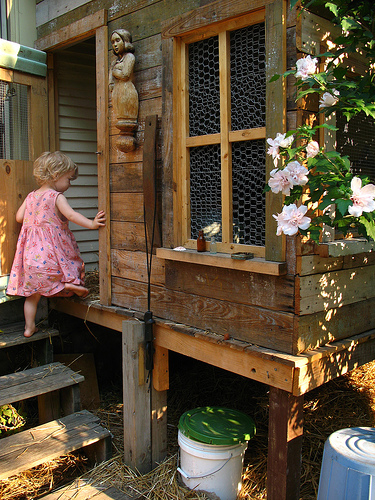

In [108]:
def turnId2W(ids):
    return ' '.join([id2w[id] for id in ids])

print(turnId2W(name_ids_dict[names_from_dict[0]]))
names_from_dict = list(name_ids_dict.keys())
Image.open(imgpath+ names_from_dict[0])


## Word vectors

In [109]:
def load_glove_me(loc):
    w2v = {}
    for line in open(loc):
        l = line.split()
        w2v[l[0]] = np.array(l[1:], dtype=np.float32)
    return w2v

In [111]:
w2v = load_glove_me(embed_path)
n_en_vec = len(w2v.keys()) #number of words encoded
dim_en_vec = len(w2v['the']) #dimension of embeddings -- we just use 'the' as a way to get it.

In [112]:
w2v['king'][:10]

array([ 0.0033901 , -0.34614   ,  0.28143999,  0.48381999,  0.59469002,
        0.012965  ,  0.53982002,  0.48232999,  0.21462999, -1.02489996], dtype=float32)

In [113]:
def create_emb(w2v, targ_vocab, dim_vec):
    vocab_size = len(targ_vocab)
    emb = np.zeros((vocab_size, dim_vec)) #initialize empty container
    found=0
    for i, word in enumerate(targ_vocab): 
        try: emb[i] = w2v[word]; found+=1 #if we find it, use the word's vecotrs
        except KeyError: emb[i] = np.random.normal(scale=0.6, size=(dim_vec,)) #else randomeness

    return emb, found

In [114]:
embs, found = create_emb(w2v, vocab, dim_en_vec); embs.shape, found

((3821, 300), 3690)

## Prep data

In [115]:
lens = sorted(list(map(len, ids))); lens[-1]

35

In [150]:
maxlen = 30
def padAndEOS(ids, maxlen=30):
    ids = list(map(lambda x: x + [EOS], ids))
    return pad_sequences(ids, maxlen, 'int64', "post", "post")
    padded = padAndEOS(ids)
turnId2W(padded[0])

'a child in a pink dress is climbing up a set of stairs in an entry way . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

## Data Loading

In [255]:
BATCH_SIZE=4
mu = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
scaleCrop = transforms.Compose([transforms.Scale(299), transforms.CenterCrop((299, 299))])

norm = transforms.Normalize(mean=mu,std=std)
mu_rev = torch.FloatTensor(mu).unsqueeze(1).unsqueeze(1)
std_rev = torch.FloatTensor(std).unsqueeze(1).unsqueeze(1)
preproc = transforms.Compose([scaleCrop, transforms.ToTensor(), norm])
denorm = transforms.Lambda(lambda x: (x * torch.FloatTensor(std_rev)) + torch.FloatTensor(mu_rev))
revTrans = transforms.Compose([denorm, transforms.ToPILImage()])
ds = ImageFolder(imgpath+'train/', transform=preproc)
dl = DataLoader(ds,batch_size=BATCH_SIZE)


In [275]:
def ImgCapLoader(dl, caps_dict, batch_size=BATCH_SIZE):
    dl.dataset.imgs = [(path, int(clazz)) for path, clazz in np.random.permutation(dl.dataset.imgs)]
    img_names = dl.dataset.imgs
    num_batches = len(img_names) // batch_size
    dl_iter = dl.__iter__()
    for i in range(0, len(img_names), batch_size):
        basenames = [path.basename(name) for name, clz in img_names[i:i+batch_size]]
        ids = np.vstack(padAndEOS([caps_dict[name] for name in basenames]))
        imgs, _ = dl_iter.__next__()
        yield imgs, ids

### Training

In [282]:
gen = ImgCapLoader(dl, name_ids_dict)

In [287]:
enc = inception_v3(pretrained=True)
targ_layer = enc._modules.get('Mixed_7c')
out = torch.zeros([BATCH_SIZE, 2048, 8, 8])
def fun(m, i, o): out.copy_(o.data)
h = targ_layer.register_forward_hook(fun)

/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/torchvision-0.1.9-py3.6.egg/torchvision/models/inception.py:65: UserWarning: src is not broadcastable to dst, but they have the same number of elements.  Falling back to deprecated pointwise behavior.


In [288]:
def train(loader, encoder, encoder_out_tensor, decoder, epochs=1):
    for imgs, ids in gen:
        _ = encoder(Variable(imgs))
        pdb.set_trace()
        

In [289]:
train(gen, enc, out, None)

> <ipython-input-288-88f14825b36b>(2)train()
-> for imgs, ids in gen:
(Pdb) out.size()
torch.Size([4, 2048, 8, 8])
(Pdb) out[0, 0, :3, :3]

 0.0000  0.0891  0.0000
 0.0000  0.0000  0.0000
 0.8918  0.0000  0.0000
[torch.FloatTensor of size 3x3]

(Pdb) 

 0.0000  0.0891  0.0000
 0.0000  0.0000  0.0000
 0.8918  0.0000  0.0000
[torch.FloatTensor of size 3x3]

(Pdb) out[3, 0, :3, :3]

 1.6388  2.2073  0.4054
 2.0414  1.6154  0.4039
 0.1193  0.0000  1.1228
[torch.FloatTensor of size 3x3]

(Pdb) c
> <ipython-input-288-88f14825b36b>(2)train()
-> for imgs, ids in gen:
(Pdb) out[3, 0, :3, :3]

 0.1518  0.0000  0.0000
 0.0000  0.0000  0.0000
 0.0000  0.0000  0.0000
[torch.FloatTensor of size 3x3]

(Pdb) out[1, 29, :3, :3]

 0.0000  0.0000  0.0000
 0.0000  0.1082  0.2297
 0.3043  0.5894  0.2930
[torch.FloatTensor of size 3x3]

(Pdb) exit


BdbQuit: 

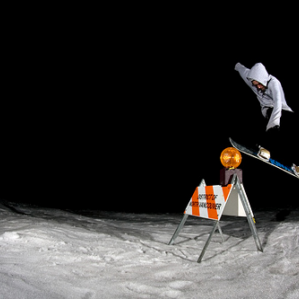

In [274]:
revTrans(imgs[3])

In [269]:
turnId2W(ids[3])

'a long snowboarder jumping over a barricade outside in the snow . <EOS> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

In [253]:
for imgs, ids in gen:
    pdb.set_trace()
    print(1)

> <ipython-input-251-cf5ee7eac733>(3)ImgCapLoader()
-> dl.dataset.imgs = [(path, int(clazz)) for path, clazz in np.random.permutation(dl.dataset.imgs)]
(Pdb) n
> <ipython-input-251-cf5ee7eac733>(4)ImgCapLoader()
-> img_names = dl.dataset.imgs
(Pdb) n
> <ipython-input-251-cf5ee7eac733>(5)ImgCapLoader()
-> num_batches = len(img_names) // batch_size
(Pdb) n
> <ipython-input-251-cf5ee7eac733>(6)ImgCapLoader()
-> dl_iter = dl.__iter__()
(Pdb) n
> <ipython-input-251-cf5ee7eac733>(7)ImgCapLoader()
-> for i in range(0, len(img_names), batch_size):
(Pdb) n
> <ipython-input-251-cf5ee7eac733>(8)ImgCapLoader()
-> basenames = [path.basename(name) for name, clz in img_names[i:i+batch_size]]
(Pdb) n
> <ipython-input-251-cf5ee7eac733>(9)ImgCapLoader()
-> ids = np.vstack(padAndEOS([caps_dict[name] for name in basenames]))
(Pdb) n
> <ipython-input-251-cf5ee7eac733>(10)ImgCapLoader()
-> imgs, _ = dl_iter.__next__()
(Pdb) ids.shape
(4, 30)
(Pdb) ids[0, :]
array([   3,   31,   11,   64,  130,    8,    3,  

BdbQuit: 

And of course we need to separate our training and test sets...

In [24]:
from sklearn import model_selection
fr_train, fr_test, en_train, en_test = model_selection.train_test_split(
    fr_padded, en_padded, test_size=0.1)

[o.shape for o in (fr_train, fr_test, en_train, en_test)]

[(47097, 30), (5234, 30), (47097, 30), (5234, 30)]

## Model

### Basic encoder-decoder

In [28]:
def long_t(arr): return Variable(torch.LongTensor(arr)) #.cuda()

In [29]:
fr_emb_t = torch.FloatTensor(fr_embs) #.cuda()
en_emb_t = torch.FloatTensor(en_embs) #.cuda()

In [30]:
def create_emb(emb_mat, non_trainable=False):
    output_size, emb_size = emb_mat.size() # get size
    emb = nn.Embedding(output_size, emb_size) #lookup table for embeddings
    emb.load_state_dict({'weight': emb_mat}) #load pretrained embeddings into embedding lookup
    if non_trainable:
        for param in emb.parameters(): 
            param.requires_grad = False
    return emb, emb_size, output_size

Turning a sequence into a representation can be done using an RNN (called the 'encoder'. This approach is useful because RNN's are able to keep track of state and memory, which is obviously important in forming a complete understanding of a sentence.
* `bidirectional=True` passes the original sequence through an RNN, and the reversed sequence through a different RNN and concatenates the results. This allows us to look forward and backwards.
* We do this because in language things that happen later often influence what came before (i.e. in Spanish, "el chico, la chica" means the boy, the girl; the word for "the" is determined by the gender of the subject, which comes after).

In [31]:
class EncoderRNN(nn.Module): #inherit from nn.Module
    def __init__(self, embs, hidden_size, n_layers=2):
        super(EncoderRNN, self).__init__()
        self.emb, emb_size, output_size = create_emb(embs, True) #get encoding embedding lookup
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(emb_size, hidden_size, batch_first=True, num_layers=n_layers)
#                          ,bidirectional=True)
        
    def forward(self, input, hidden):
        return self.gru(self.emb(input), hidden)

    def initHidden(self, batch_size):
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))

In [57]:
def encode(inp, encoder):
    batch_size, input_length = inp.size()
    hidden = encoder.initHidden(batch_size) #.cuda() 
    enc_outputs, hidden = encoder(inp, hidden) #run inpupts through encoder
    return long_t([SOS]*batch_size), enc_outputs, hidden #return outputs, hidden state, and a sequences of SOS    

Finally, we arrive at a vector representation of the sequence which captures everything we need to translate it. We feed this vector into more RNN's, which are trying to generate the labels. After this, we make a classification for what each word is in the output sequence.

In [33]:
class DecoderRNN(nn.Module):
    def __init__(self, embs, hidden_size, n_layers=2):
        super(DecoderRNN, self).__init__()
        self.emb, emb_size, output_size = create_emb(embs)
        self.gru = nn.GRU(emb_size, hidden_size, batch_first=True, num_layers=n_layers)
        self.out = nn.Linear(hidden_size, output_size) #Dense layer on top of rnn
        
    def forward(self, inp, hidden):
        emb = self.emb(inp).unsqueeze(1) #get embeddings and and new axis
        res, hidden = self.gru(emb, hidden) #run embeddings through decoder rnn
        res = F.log_softmax(self.out(res[:,0])) # dense layer and softmax to get scores
        return res, hidden

This graph demonstrates the accuracy decay for a neural translation task. With an encoding/decoding technique, larger input sequences result in less accuracy.

<img src="https://smerity.com/media/images/articles/2016/bahdanau_attn.png" width="600">

This can be mitigated using an attentional model.

### Adding broadcasting to Pytorch

Using *broadcasting* makes a lot of numerical programming far simpler. Here's a couple of examples, using numpy:

In [32]:
v=np.array([1,2,3]); v, v.shape

(array([1, 2, 3]), (3,))

In [33]:
m=np.array([v,v*2,v*3]); m, m.shape

(array([[1, 2, 3],
        [2, 4, 6],
        [3, 6, 9]]), (3, 3))

In [34]:
m+v

array([[ 2,  4,  6],
       [ 3,  6,  9],
       [ 4,  8, 12]])

In [35]:
v1=np.expand_dims(v,-1); v1, v1.shape

(array([[1],
        [2],
        [3]]), (3, 1))

In [36]:
m+v1

array([[ 2,  3,  4],
       [ 4,  6,  8],
       [ 6,  9, 12]])

But Pytorch doesn't support broadcasting. So let's add it to the basic operators, and to a general tensor torch.matmul product:

In [44]:
def unit_prefix(x, n=1):
    for i in range(n): x = x.unsqueeze(0)
    return x

def align(x, y, start_dim=2):
    xd, yd = x.dim(), y.dim()
    if xd > yd: y = unit_prefix(y, xd - yd)
    elif yd > xd: x = unit_prefix(x, yd - xd)

    xs, ys = list(x.size()), list(y.size())
    nd = len(ys)
    for i in range(start_dim, nd):
        td = nd-i-1
        if   ys[td]==1: ys[td] = xs[td]
        elif xs[td]==1: xs[td] = ys[td]
    return x.expand(*xs), y.expand(*ys)

In [45]:
def aligned_op(x,y,f): return f(*align(x,y,0))

def add(x, y): return aligned_op(x, y, operator.add)
def sub(x, y): return aligned_op(x, y, operator.sub)
def mul(x, y): return aligned_op(x, y, operator.mul)
def div(x, y): return aligned_op(x, y, operator.truediv)

In [38]:
def dot(x, y):
    assert(1<y.dim()<5)
    x, y = align(x, y)
    
    if y.dim() == 2: return x.mm(y)
    elif y.dim() == 3: return x.bmm(y)
    else:
        xs,ys = x.size(), y.size()
        res = torch.zeros(*(xs[:-1] + (ys[-1],)))
        for i in range(xs[0]): res[i].baddbmm_(x[i], (y[i]))
        return res

Let's test!

In [34]:
def Arr(*sz): return torch.randn(sz)/math.sqrt(sz[0])

In [48]:
m = Arr(3, 2); m2 = Arr(4, 3)
v = Arr(2)
b = Arr(4,3,2); t = Arr(5,4,3,2)

mt,bt,tt = m.transpose(0,1), b.transpose(1,2), t.transpose(2,3)

In [49]:
def check_eq(x,y): assert(torch.equal(x,y))

In [50]:
check_eq(torch.matmul(m,mt),m.mm(mt))
check_eq(torch.matmul(v,mt), v.unsqueeze(0).mm(mt))
check_eq(torch.matmul(b,bt),b.bmm(bt))
check_eq(torch.matmul(b,mt),b.bmm(unit_prefix(mt).expand_as(bt)))

In [51]:
exp = t.view(-1,3,2).bmm(tt.contiguous().view(-1,2,3)).view(5,4,3,3)
check_eq(torch.matmul(t,tt),exp)

In [54]:
check_eq(add(m,v),m+unit_prefix(v).expand_as(m))
check_eq(add(v,m),m+unit_prefix(v).expand_as(m))
check_eq(add(m,t),t+unit_prefix(m,2).expand_as(t))
check_eq(sub(m,v),m-unit_prefix(v).expand_as(m))
check_eq(mul(m,v),m*unit_prefix(v).expand_as(m))
check_eq(div(m,v),m/unit_prefix(v).expand_as(m))

### Attentional model

In [46]:
def Var(*sz): return nn.Parameter(Arr(*sz))#.cuda()

In [124]:
class AttnDecoderRNNMe(nn.Module):
    def __init__(self, embs, hidden_size, n_layers=2, p=0.1):
        super(AttnDecoderRNNMe, self).__init__()
        self.emb, emb_size, output_size = create_emb(embs)
        self.W1 = Var(hidden_size, hidden_size)
        self.W2 = Var(hidden_size, hidden_size)
        self.W3 = Var(emb_size+hidden_size, hidden_size)
        self.b2 = Var(hidden_size)
        self.b3 = Var(hidden_size)
        self.V = Var(hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=2)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, inp, hidden, enc_outputs):
        emb_inp = self.emb(inp)
        w1e = torch.matmul(enc_outputs, self.W1) #transform encoder outputs 
        w2h = (torch.matmul(hidden[-1], self.W2) + self.b2).unsqueeze(1) #transform current hidden state
        u = F.tanh(w1e + w2h) #add two together and non-linearity
        a = (self.V * u).sum(2)#.squeeze(2) # get attention scores
        a = F.softmax(a).unsqueeze(2) #normalize attention scores
        Xa = (a * enc_outputs).sum(1) # weighted sum over encoder outputs given attention weights
        #concat with decoder input and transform to correct size
        res = torch.matmul(torch.cat([emb_inp, Xa.squeeze(1)], 1), self.W3)
        res = (res + self.b3).unsqueeze(0)
        res, hidden = self.gru(res, hidden)
        #dense layer and softmax at top
        res = F.log_softmax(self.out(res.squeeze(0)))
        return res, hidden

In [113]:
''' class AttnDecoderRNN(nn.Module):
    def __init__(self, embs, hidden_size, n_layers=2, p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.emb, emb_size, output_size = create_emb(embs)
        self.W1 = Var(hidden_size, hidden_size)
        self.W2 = Var(hidden_size, hidden_size)
        self.W3 = Var(emb_size+hidden_size, hidden_size)
        self.b2 = Var(hidden_size)
        self.b3 = Var(hidden_size)
        self.V = Var(hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=2)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, inp, hidden, enc_outputs):
        emb_inp = self.emb(inp)
        w1e = torch.matmul(enc_outputs, self.W1)
        w2h = add(torch.matmul(hidden[-1], self.W2), self.b2).unsqueeze(1)
        u = F.tanh(add(w1e, w2h))
        a = mul(self.V,u).sum(2).squeeze(2)
        a = F.softmax(a).unsqueeze(2)
        Xa = mul(a, enc_outputs).sum(1)
        res = torch.matmul(torch.cat([emb_inp, Xa.squeeze(1)], 1), self.W3)
        res = add(res, self.b3).unsqueeze(0)
        res, hidden = self.gru(res, hidden)
        res = F.log_softmax(self.out(res.squeeze(0)))
        return res, hidden
'''

' class AttnDecoderRNN(nn.Module):\n    def __init__(self, embs, hidden_size, n_layers=2, p=0.1):\n        super(AttnDecoderRNN, self).__init__()\n        self.emb, emb_size, output_size = create_emb(embs)\n        self.W1 = Var(hidden_size, hidden_size)\n        self.W2 = Var(hidden_size, hidden_size)\n        self.W3 = Var(emb_size+hidden_size, hidden_size)\n        self.b2 = Var(hidden_size)\n        self.b3 = Var(hidden_size)\n        self.V = Var(hidden_size)\n        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=2)\n        self.out = nn.Linear(hidden_size, output_size)\n\n    def forward(self, inp, hidden, enc_outputs):\n        emb_inp = self.emb(inp)\n        w1e = torch.matmul(enc_outputs, self.W1)\n        w2h = add(torch.matmul(hidden[-1], self.W2), self.b2).unsqueeze(1)\n        u = F.tanh(add(w1e, w2h))\n        a = mul(self.V,u).sum(2).squeeze(2)\n        a = F.softmax(a).unsqueeze(2)\n        Xa = mul(a, enc_outputs).sum(1)\n        res = torch.matmul(torch.cat

### Attention testing

Pytorch makes it easy to check intermediate results, when creating a custom architecture such as this one, since you can interactively run each function.

In [50]:
def get_batch(x, y, batch_size=16):
    idxs = np.random.permutation(len(x))[:batch_size]
    return x[idxs], y[idxs]

In [99]:
hidden_size = 128
fra, eng = get_batch(fr_train, en_train, 4)
inp = long_t(fra)
targ = long_t(eng)
emb, emb_size, output_size = create_emb(en_emb_t)
#emb#.cuda()
inp.size()

torch.Size([4, 30])

In [100]:
#create weights and biases
W1 = Var(hidden_size, hidden_size)
W2 = Var(hidden_size, hidden_size)
W3 = Var(emb_size+hidden_size, hidden_size)
b2 = Var(1,hidden_size)
b3 = Var(1,hidden_size)
V = Var(1,1,hidden_size)

gru = nn.GRU(hidden_size, hidden_size, num_layers=2)#.cuda()
out = nn.Linear(hidden_size, output_size)#.cuda()
encoder = EncoderRNN(embs=en_emb_t, hidden_size=hidden_size)

In [101]:
#dec_inputs is start of sentence tokens, enc_outtput is output from last layer of encoder GRU, 
#hidden are the hidden states for the conder rnn
dec_inputs, enc_outputs, hidden = encode(inp, encoder)
enc_outputs.size(), hidden.size()

(torch.Size([4, 30, 128]), torch.Size([2, 4, 128]))

In [111]:
#embed decoder inputs
emb_inp = emb(dec_inputs); emb_inp.size()

torch.Size([4, 100])

In [103]:
#enc_outputs (batch, seq_len, hid_dim)
w1e = torch.matmul(enc_outputs, W1); w1e.size() 

torch.Size([4, 30, 128])

In [104]:
# hidden[-1] last layer of hidden state from encoder -- or the current hidden state of the decoder(batch, hid_dim)
w2h = torch.matmul(hidden[-1], W2)
w2h = (w2h+b2.expand_as(w2h)).unsqueeze(1); w2h.size()

torch.Size([4, 1, 128])

In [105]:
u = F.tanh(w1e + w2h.expand_as(w1e))
a = (V.expand_as(u)*u).sum(2)#.squeeze(2)
a = F.softmax(a).unsqueeze(2); a.size(),a.sum(1).squeeze(1)

(torch.Size([4, 30, 1]), Variable containing:
  1
  1
  1
  1
 [torch.FloatTensor of size 4])

In [106]:
#multpily your attention weights by their corresponding encoder outputs, then sum them. 
#This is our attentional weighted sum.
Xa = (a.expand_as(enc_outputs) * enc_outputs).sum(1); Xa.size()

torch.Size([4, 128])

In [107]:
#concatenate attentional vector with decoder input, then do a transformation to get to the correct size
#output is on slice of time to put through gru (1, batch, hidden_dim)
res = torch.matmul(torch.cat([emb_inp, Xa.squeeze(1)], 1), W3)
res = (res+b3.expand_as(res)).unsqueeze(0); res.size()

torch.Size([1, 4, 128])

In [108]:
#run through gru
res, hidden = gru(res, hidden); res.size(), hidden.size()

(torch.Size([1, 4, 128]), torch.Size([2, 4, 128]))

In [109]:
#dens linear layer, followed by log_softmax to get probabilities for each word in your vocabulary
res = F.log_softmax(out(res.squeeze(0))); res.size()

torch.Size([4, 19549])

## Train

Pytorch has limited functionality for training models automatically - you will generally have to write your own training loops. However, Pytorch makes it far easier to customize how this training is done, such as using *teacher forcing*.

In [125]:
def train(inp, targ, encoder, decoder, enc_opt, dec_opt, crit):
    decoder_input, encoder_outputs, hidden = encode(inp, encoder) #encoder
    target_length = targ.size()[1] 
    
    enc_opt.zero_grad(); dec_opt.zero_grad()
    loss = 0

    for di in range(target_length):
        decoder_output, hidden = decoder(decoder_input, hidden, encoder_outputs) #get output hidden
        decoder_input = targ[:, di] #next decoder input (teacher forcing)
        loss += crit(decoder_output, decoder_input) #compute loss

    loss.backward()
    enc_opt.step(); dec_opt.step()
    return loss.data[0] / target_length

In [126]:
def req_grad_params(o):
    return (p for p in o.parameters() if p.requires_grad)

In [127]:
def trainEpochs(encoder, decoder, n_epochs, print_every=1000, lr=0.01):
    loss_total = 0 # Reset every print_every
    
    enc_opt = optim.RMSprop(req_grad_params(encoder), lr=lr)
    dec_opt = optim.RMSprop(decoder.parameters(), lr=lr)
    crit = nn.NLLLoss()#.cuda()
    
    for epoch in range(n_epochs):
        fra, eng = get_batch(fr_train, en_train, 64)
        inp = long_t(fra)
        targ = long_t(eng)
        loss = train(inp, targ, encoder, decoder, enc_opt, dec_opt, crit)
        loss_total += loss

        if epoch % print_every == print_every-1:
            print('%d %d%% %.4f' % (epoch, epoch / n_epochs * 100, loss_total / print_every))
            loss_total = 0

## Run

In [128]:
hidden_size = 128
encoder = EncoderRNN(fr_emb_t, hidden_size)#.cuda()
decoder = AttnDecoderRNNMe(en_emb_t, hidden_size)#.cuda()

In [130]:
trainEpochs(encoder, decoder, 10000, print_every=10, lr=0.005)

9 0% 4.7934
19 0% 3.6304
29 0% 3.1288


KeyboardInterrupt: 

## Testing

In [131]:
def evaluate(inp):
    decoder_input, encoder_outputs, hidden = encode(inp, encoder) #encode and get SOS, encoder_out and hidden
    target_length = maxlen

    decoded_words = []
    for di in range(target_length):
        decoder_output, hidden = decoder(decoder_input, hidden, encoder_outputs) #run through decoder 
        topv, topi = decoder_output.data.topk(1) #pick top probability
        ni = topi[0][0]
        if ni==PAD: break
        decoded_words.append(en_vocab[ni])
        decoder_input = long_t([ni]) #make prediction next decoder input (no teacher forcing)
    
    return decoded_words

In [235]:
def sent2ids(sent):
    ids = [fr_w2id[t] for t in simple_toks(sent)]
    return pad_sequences([ids], maxlen, 'int64', "post", "post")

In [236]:
def fr2en(sent): 
    ids = long_t(sent2ids(sent))
    trans = evaluate(ids)
    return ' '.join(trans)

In [237]:
i=8
print(en_qs[i],fr_qs[i])
fr2en(fr_qs[i])

What is the population of Canada? Quelle est la population du Canada ?


"what is canada 's population ?"